## Laboratory 05 - Modeling and Simulation

- Kristopher Javier Alvarado López
- David Jonathan Aragon Vasquez
- Renatto Esteban Guzman Sosa

## Inciso 1

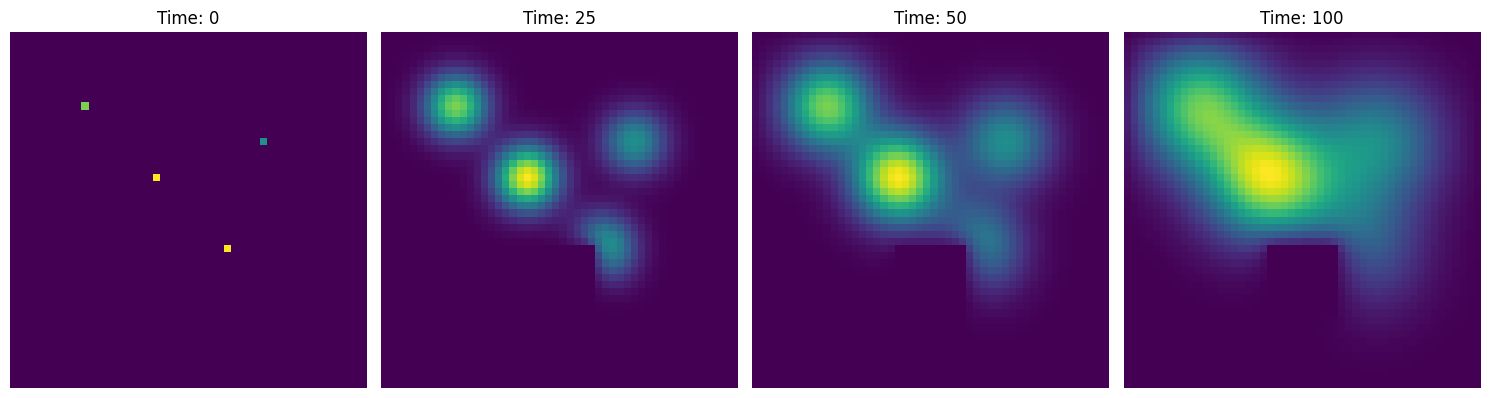

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def difusion_automata(M, N, T, u0, K, mask=None):
    u = np.copy(u0)
    historial = [u.copy()]

    def obtener_vecinos(i, j):
        vecinos = [(i-1, j), (i+1, j), (i, j-1), (i, j+1), 
                   (i-1, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)]
        # Retornar solo los vecinos válidos dentro del grid
        return [(x, y) for x, y in vecinos if 0 <= x < M and 0 <= y < N]
    
    for t in range(T):
        nuevo_u = np.copy(u)
        for i in range(M):
            for j in range(N):
                if mask is None or mask[i, j]:  # Si hay máscara, solo actualizamos en las celdas válidas
                    suma_vecinos = 0
                    vecinos = obtener_vecinos(i, j)
                    for x, y in vecinos:
                        suma_vecinos += u[x, y]
                    # Actualización según la ecuación de difusión
                    nuevo_u[i, j] = (1 - K) * u[i, j] + K * (suma_vecinos / 8)
        u = nuevo_u
        historial.append(u.copy())
    
    return historial

def graficar_secuencia(historial, tiempos):
    fig, axs = plt.subplots(1, len(tiempos), figsize=(15, 5))
    
    for idx, t in enumerate(tiempos):
        axs[idx].imshow(historial[t], cmap='viridis', interpolation='nearest')
        axs[idx].set_title(f'Time: {t}')
        axs[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Parámetros de simulación
M, N = 50, 50  # Tamaño del grid
T = 100        # Tiempo de simulación
K = 0.5        # Parámetro de difusión

# Distribución inicial
u0 = np.zeros((M, N))
u0[20, 20] = 1.0
u0[30, 30] = 1.0
u0[10, 10] = 0.8
u0[15, 35] = 0.5


# Máscara para región L (opcional)
mask = np.ones((M, N), dtype=bool)
mask[30:40, 20:30] = False  # Definir un agujero en forma de L

# Ejecutar simulación
historial = difusion_automata(M, N, T, u0, K, mask)

# Graficar evolución en tiempos específicos
tiempos = [0, 25, 50, 100]  # Momentos de tiempo a graficar
graficar_secuencia(historial, tiempos)


## Inciso 2

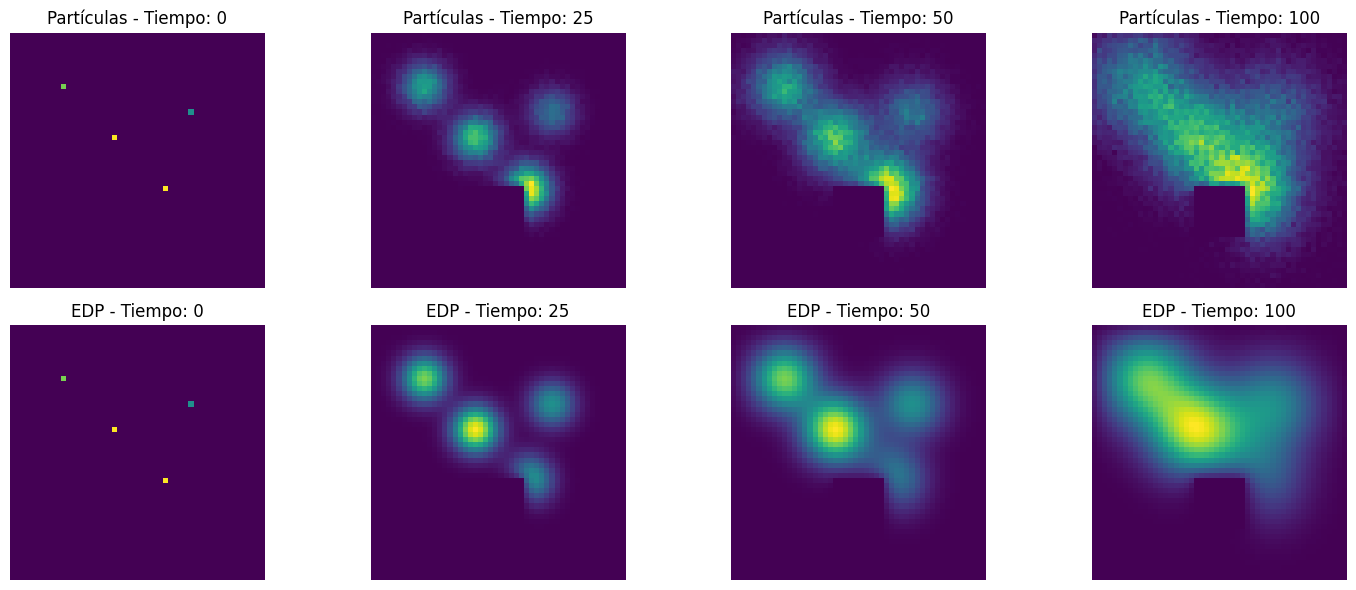

In [2]:
import matplotlib.animation as animation

def difusion_particulas(M, N, T, u0, K, P, Nexp, mask=None):
    # Inicialización del promedio acumulativo de las simulaciones
    acumulado_historial = [np.zeros((M, N)) for _ in range(T+1)]
    
    for exp in range(Nexp):
        # Inicializar partículas según u0
        # Normalizar u0 para que sume a 1 (probabilidades)
        prob_u0 = u0.flatten()
        prob_u0 = prob_u0 / np.sum(prob_u0)
        
        # Generar posiciones iniciales de las partículas
        indices = np.arange(M*N)
        posiciones_iniciales = np.random.choice(indices, size=P, p=prob_u0)
        posiciones = np.array(np.unravel_index(posiciones_iniciales, (M, N))).T  # Coordenadas (i, j)
        
        # Historial para esta simulación
        historial = [np.zeros((M, N))]
        for pos in posiciones:
            historial[0][pos[0], pos[1]] += 1
        
        for t in range(1, T+1):
            nueva_posiciones = []
            for idx, pos in enumerate(posiciones):
                i, j = pos
                if mask is None or mask[i, j]:  # Verificar si la posición actual es válida
                    if np.random.rand() < K:
                        # Moverse a un vecino aleatorio
                        vecinos = [(i-1, j), (i+1, j), (i, j-1), (i, j+1),
                                   (i-1, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)]
                        # Filtrar vecinos válidos
                        vecinos_validos = [(x, y) for x, y in vecinos if 0 <= x < M and 0 <= y < N]
                        if mask is not None:
                            vecinos_validos = [(x, y) for x, y in vecinos_validos if mask[x, y]]
                        if vecinos_validos:
                            nueva_pos = vecinos_validos[np.random.randint(len(vecinos_validos))]
                            posiciones[idx] = nueva_pos
                # Si no se mueve, se queda en la misma posición
                nueva_posiciones.append(posiciones[idx])
            posiciones = nueva_posiciones.copy()
            
            # Actualizar el historial
            grid = np.zeros((M, N))
            for pos in posiciones:
                grid[pos[0], pos[1]] += 1
            historial.append(grid)
        
        # Acumular el historial
        for t in range(T+1):
            acumulado_historial[t] += historial[t]
    
    # Promediar las simulaciones
    promedio_historial = [h / Nexp for h in acumulado_historial]
    return promedio_historial

def generar_video(historial, filename='difusion_particulas.mp4'):
    fig = plt.figure()
    ims = []
    for data in historial:
        im = plt.imshow(data, cmap='viridis', animated=True, interpolation='nearest')
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)
    ani.save(filename)
    plt.close()

def comparar_con_EDP(historial_particulas, historial_EDP, tiempos):
    fig, axs = plt.subplots(2, len(tiempos), figsize=(15, 6))
    
    for idx, t in enumerate(tiempos):
        # Simulación de partículas
        axs[0, idx].imshow(historial_particulas[t], cmap='viridis', interpolation='nearest')
        axs[0, idx].set_title(f'Partículas - Tiempo: {t}')
        axs[0, idx].axis('off')
        
        # Simulación EDP
        axs[1, idx].imshow(historial_EDP[t], cmap='viridis', interpolation='nearest')
        axs[1, idx].set_title(f'EDP - Tiempo: {t}')
        axs[1, idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Parámetros de simulación
M, N = 50, 50  # Tamaño del grid
T = 100        # Tiempo de simulación
K = 0.5        # Parámetro de difusión
P = 10000      # Número de partículas
Nexp = 10      # Número de experimentos

# Distribución inicial
u0 = np.zeros((M, N))
u0[20, 20] = 1.0
u0[30, 30] = 1.0
u0[10, 10] = 0.8
u0[15, 35] = 0.5

# Máscara para región L (opcional)
mask = np.ones((M, N), dtype=bool)
mask[30:40, 20:30] = False  # Definir un agujero en forma de L

# Ejecutar simulación de partículas
historial_particulas = difusion_particulas(M, N, T, u0, K, P, Nexp, mask)

# Normalizar el promedio a una escala de probabilidad
historial_particulas_normalizado = [h / np.sum(h) for h in historial_particulas]

# Generar video de la dinámica espacial
generar_video(historial_particulas_normalizado)

# Ejecutar simulación EDP del ejercicio 1 (usando el código previo)
historial_EDP = difusion_automata(M, N, T, u0, K, mask)

# Graficar comparación en tiempos específicos
tiempos = [0, 25, 50, 100]
comparar_con_EDP(historial_particulas_normalizado, historial_EDP, tiempos)


## Inciso 3

In [3]:
K_values = [0.1, 0.5, 0.9]
for K in K_values:
    historial_particulas = difusion_particulas(M, N, T, u0, K, P, Nexp, mask)
    historial_particulas_normalizado = [h / np.sum(h) for h in historial_particulas]
    generar_video(historial_particulas_normalizado, filename=f'difusion_particulas_K{K}.mp4')


In [4]:
u0_variations = [
    np.eye(M, N),                     # Distribución en diagonal
    np.ones((M, N)) * (1 / (M * N)),  # Distribución uniforme
    u0                                # La distribución original
]

for i, u0_var in enumerate(u0_variations):
    historial_particulas = difusion_particulas(M, N, T, u0_var, K, P, Nexp, mask)
    historial_particulas_normalizado = [h / np.sum(h) for h in historial_particulas]
    generar_video(historial_particulas_normalizado, filename=f'difusion_particulas_u0_{i}.mp4')
